## TOC:
* [Bartra ROI](#bartra-bullet)
* [PPC from Gilaie, Zhang, Levy](#ppc-bullet)

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
import scipy.spatial.distance as sp_distance

import nibabel as nib
import nilearn.plotting as plotting
from nilearn.input_data import NiftiMasker, NiftiSpheresMasker

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
from nltools.mask import create_sphere

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Autosaving every 5 seconds


In [2]:
base_root = '/home/rj299/scratch60/mdm_analysis/'
data_root = '/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/1stLevel/'
out_root = '/home/rj299/scratch60/mdm_analysis/output/'
anat_mean = nib.load(os.path.join(out_root, 'imaging', 'all_sub_average.nii.gz'))

In [3]:
stims = {'01': 'Med_amb_0', '02': 'Med_amb_1', '03': 'Med_amb_2', '04': 'Med_amb_3',
         '05': 'Med_risk_0', '06': 'Med_risk_1', '07': 'Med_risk_2', '08': 'Med_risk_3', 
         '09': 'Mon_amb_0', '10': 'Mon_amb_1', '11': 'Mon_amb_2', '12': 'Mon_amb_3',
         '13': 'Mon_risk_0', '14': 'Mon_risk_1', '15': 'Mon_risk_2', '16': 'Mon_risk_3'}

stim_num = len(stims)

subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 
            2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 
            2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]

In [18]:
# all rois' names
sub = 2654
roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
              allow_pickle = True)
roi_rdm = roi_rdm_obj.item()
roi_names_all = list(roi_rdm.keys())

print('All names of ROIs:')
for roi_name in roi_names_all:
    print(roi_name)

All names of ROIs:
vmpfc
vstr
med_mon_1
med_mon_2
med_mon_3
gilaie_rppc
zhang_val_lppc
zhang_val_lofc
zhang_val_lingual
zhang_sal_acc
zhang_sal_lprecentral
zhang_sal_lcaudate
zhang_sal_rcaudate
zhang_sal_linsula
zhang_sal_rinsula
zhang_sal_lingual
levy_amb_striatum
levy_amb_mpfc
levy_amb_ppc
levy_amb_lamyg
levy_amb_sts
levy_risk_striatum
levy_risk_mpfc


In [5]:
# function
def plot_roi_rdm(subjects, roi_names):
    
    for sub in subjects:
        roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
               allow_pickle = True)

        roi_rdm = roi_rdm_obj.item()

        stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
        fontdict = {'fontsize': 12}
        edges = np.array([0,4,8,12,16])-0.5

        f, ax = plt.subplots(1,len(roi_names), figsize=(15, 7))

        for roi_idx in range(len(roi_names)):
            im = ax[roi_idx].imshow(roi_rdm[roi_names[roi_idx]])
            ax[roi_idx].set_xticklabels(stim_cat, rotation = 30, fontdict = fontdict)
            ax[roi_idx].set_yticklabels(stim_cat, fontdict = fontdict)
            ax[roi_idx].set_title('RDM, '+roi_names[roi_idx] + ', %s ' %sub) 
            ax[roi_idx].set_xlabel('condition')
            if roi_idx == 0:
                ax[roi_idx].set_ylabel('condition')
            else:
                ax[roi_idx].set_ylabel('')
            ax[roi_idx].vlines(edges,min(edges),max(edges))
            ax[roi_idx].hlines(edges,min(edges),max(edges))
            f.colorbar(im, ax=ax[roi_idx], shrink = 0.5)


        f.subplots_adjust(wspace = 0.25)

        f1, ax1 = plt.subplots(1,len(roi_names), figsize=(15, 6))

        for (roi_idx, roi_name) in enumerate(roi_names):
            # Create the MDS object
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
            results = mds.fit(roi_rdm[roi_name])

            coords = results.embedding_

            value = [1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4] 
            uncert = ['Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk',
                      'Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk']
            domain = ['Med','Med','Med','Med','Med','Med','Med','Med',
                      'Mon','Mon','Mon','Mon','Mon','Mon','Mon','Mon']

            mds_coord = pd.DataFrame({'x': coords[:,0], 'y': coords[:,1], 'value': value,
                        'uncertainty': uncert, 'domain': domain})    


            sns.scatterplot(x='x', y = 'y',
                            size = 'value', hue = 'uncertainty', style = 'domain',
                            data=mds_coord, legend = 'full',
                            ax = ax1[roi_idx])

            if roi_idx == len(roi_names)-1:
                ax1[roi_idx].legend(fontsize = 12, markerscale = 1, loc = 'right', bbox_to_anchor=(1.35, .5))
            else:
                ax1[roi_idx].legend().remove()

            ax1[roi_idx].set_title('MDS, ' + roi_name + ', %s' %sub);

        f1.subplots_adjust(wspace = 0.3)    


In [16]:
def plot_roi_average_rdm(subjects, roi_names):
    roi_rdm = {}

    for roi_name in roi_names:
        roi_rdm[roi_name] = []

    for sub in subjects:
        roi_rdm_sub_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
           allow_pickle = True)

        roi_rdm_sub = roi_rdm_sub_obj.item()
    #     roi_names = list(roi_rdm_sub.keys())

        for roi_name in roi_names:
            roi_rdm[roi_name].append(roi_rdm_sub[roi_name]) 
    
    stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
    fontdict = {'fontsize': 12}
    edges = np.array([0,4,8,12,16])-0.5
    # roi_names = list(roi_rdm.keys())

    f, ax = plt.subplots(1,len(roi_names), figsize=(15, 7))

    for roi_idx in range(len(roi_names)):
        im = ax[roi_idx].imshow(np.mean(roi_rdm[roi_names[roi_idx]], axis=0))
        ax[roi_idx].set_xticklabels(stim_cat, rotation = 30, fontdict = fontdict)
        ax[roi_idx].set_yticklabels(stim_cat, fontdict = fontdict)
        ax[roi_idx].set_title('RDM '+roi_names[roi_idx] + ' %s sub Average' %len(subjects)) 
        ax[roi_idx].set_xlabel('condition')
        if roi_idx == 0:
            ax[roi_idx].set_ylabel('condition')
        else:
            ax[roi_idx].set_ylabel('')
        ax[roi_idx].vlines(edges,min(edges),max(edges))
        ax[roi_idx].hlines(edges,min(edges),max(edges))
        f.colorbar(im, ax=ax[roi_idx], shrink = 0.7)


    f.subplots_adjust(wspace = 0.25) 
    
    # MDS
    roi_rdm_mean = {}
    for roi_name in roi_names:
        roi_rdm_mean[roi_name] = np.mean(roi_rdm[roi_name], axis=0)
    
    f, ax = plt.subplots(1, len(roi_names), figsize=(15, 7))
    
    for roi_idx, roi_name in enumerate(roi_names):
        # Create the MDS object
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
        results = mds.fit(roi_rdm_mean[roi_name])

        coords = results.embedding_

        value = [1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4] 
        uncert = ['Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk',
                  'Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk']
        domain = ['Med','Med','Med','Med','Med','Med','Med','Med',
                  'Mon','Mon','Mon','Mon','Mon','Mon','Mon','Mon']

        mds_coord = pd.DataFrame({'x': coords[:,0], 'y': coords[:,1], 'value': value,
                    'uncertainty': uncert, 'domain': domain})    


        sns.scatterplot(x='x', y = 'y', 
                        size = 'value', hue = 'uncertainty', style = 'domain',
                        data=mds_coord, legend = 'full', ax = ax[roi_idx])
        
        ax[roi_idx].legend(fontsize = 12, markerscale = 1, loc = 'right', bbox_to_anchor=(1.3, .5))
        
        if roi_idx == len(roi_names)-1:
            ax[roi_idx].legend(fontsize = 12, markerscale = 1, loc = 'right', bbox_to_anchor=(1.35, .5))
        else:
            ax[roi_idx].legend().remove()

        ax[roi_idx].set_title('MDS, 2D,' + ' ' + roi_name);    

## Bartra ROI<a class="anchor" id="bartra-bullet"></a>

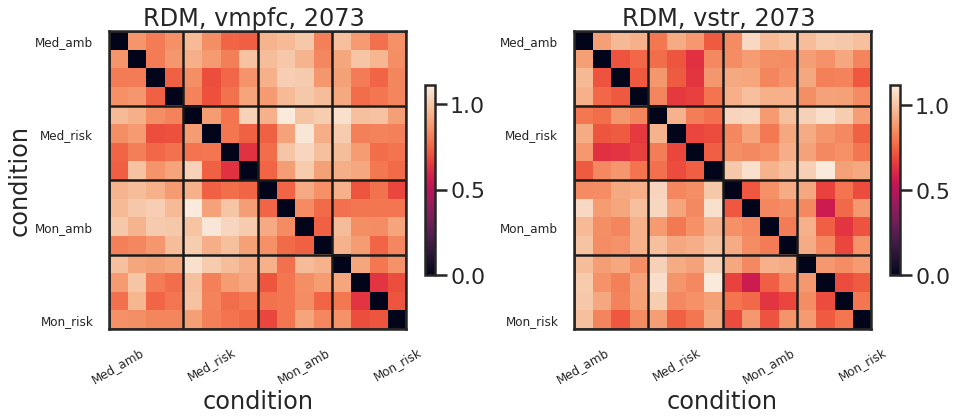

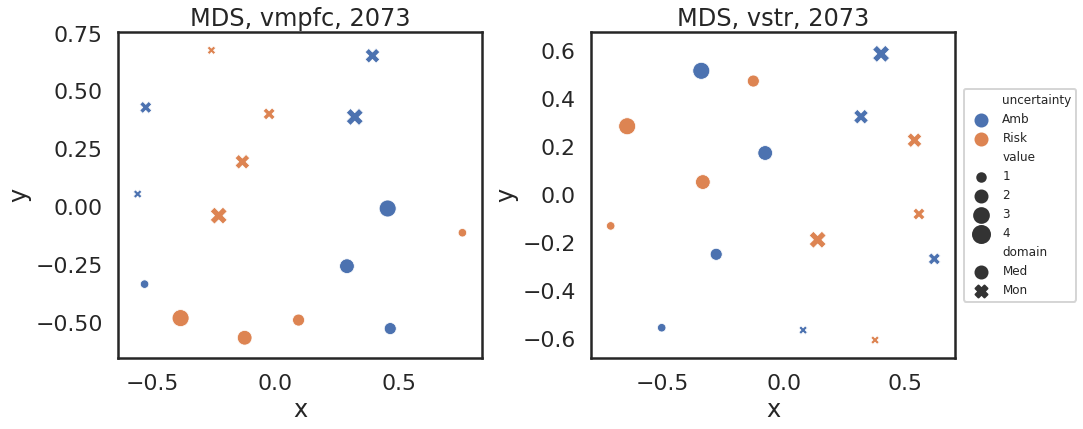

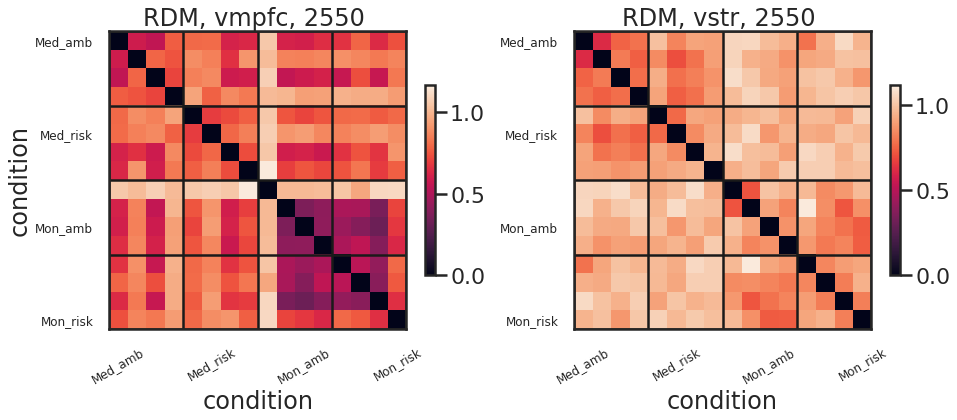

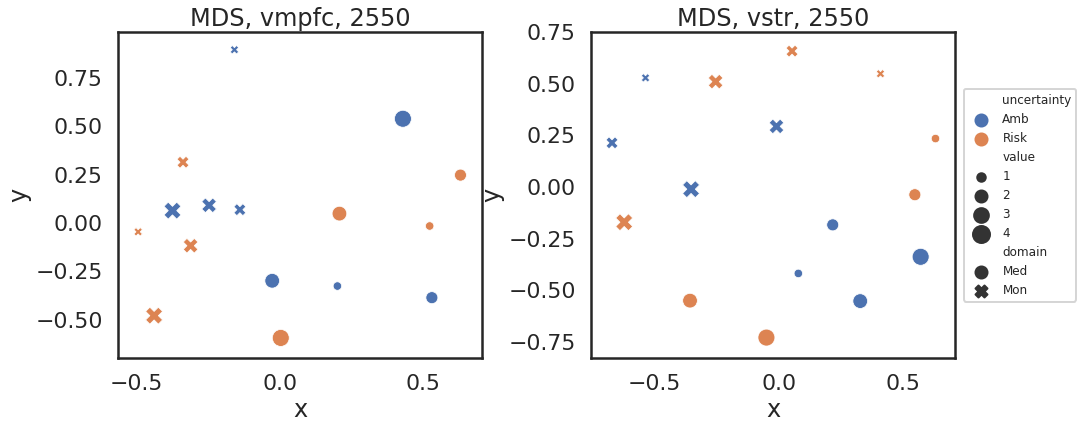

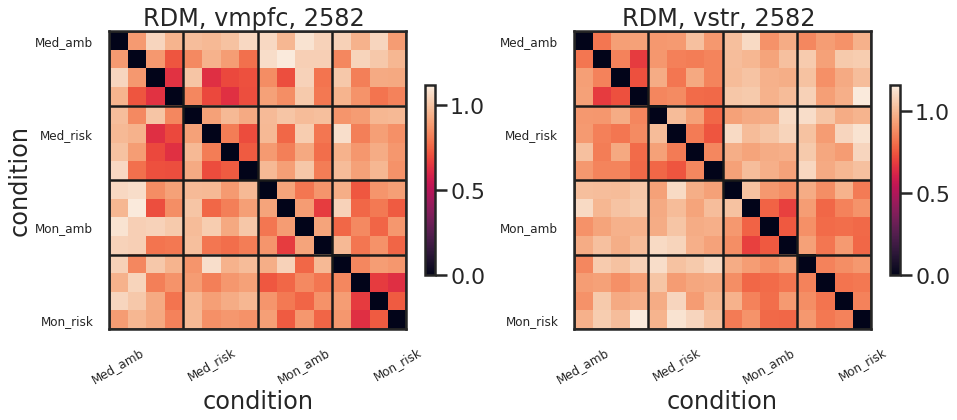

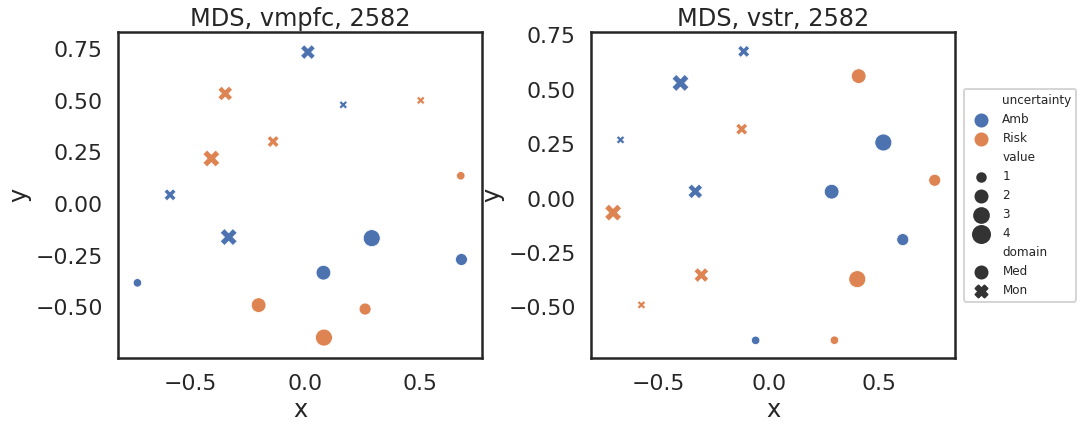

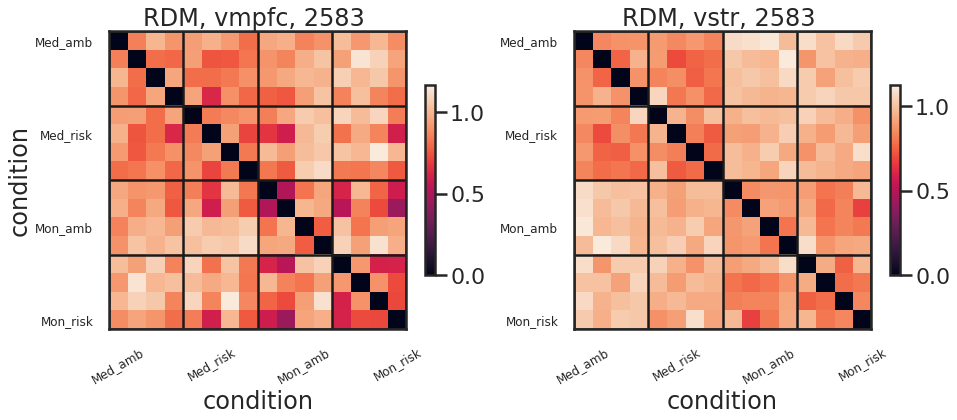

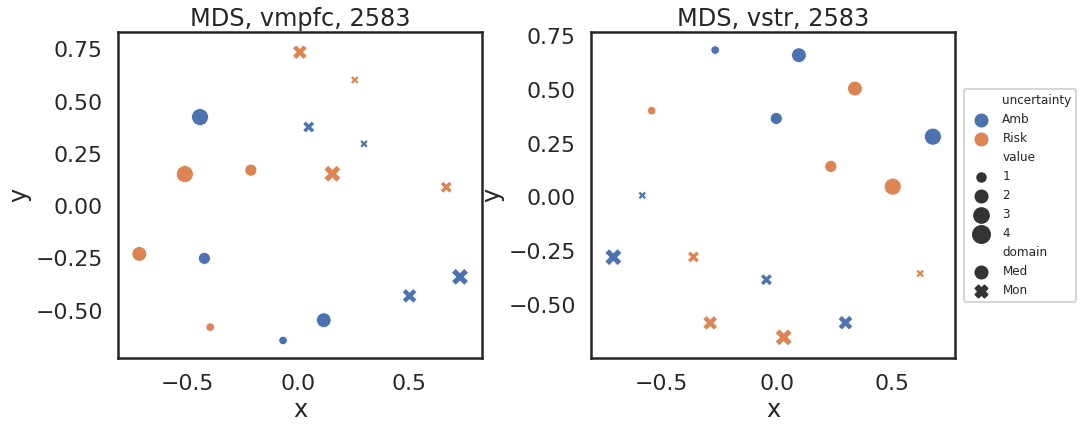

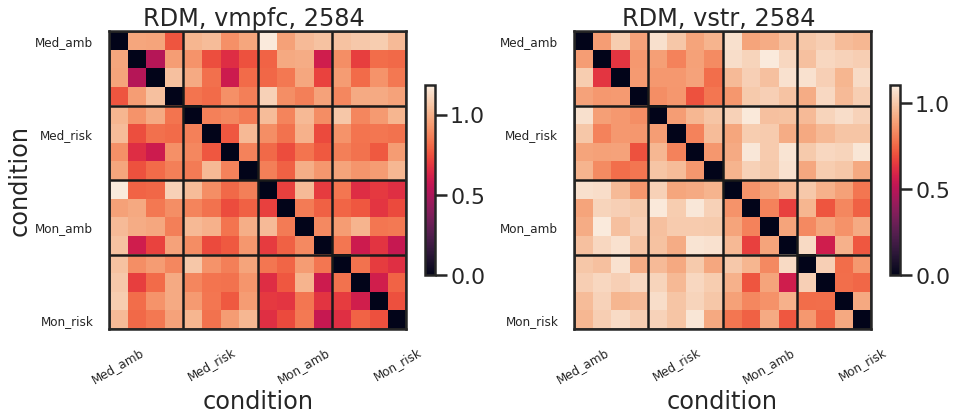

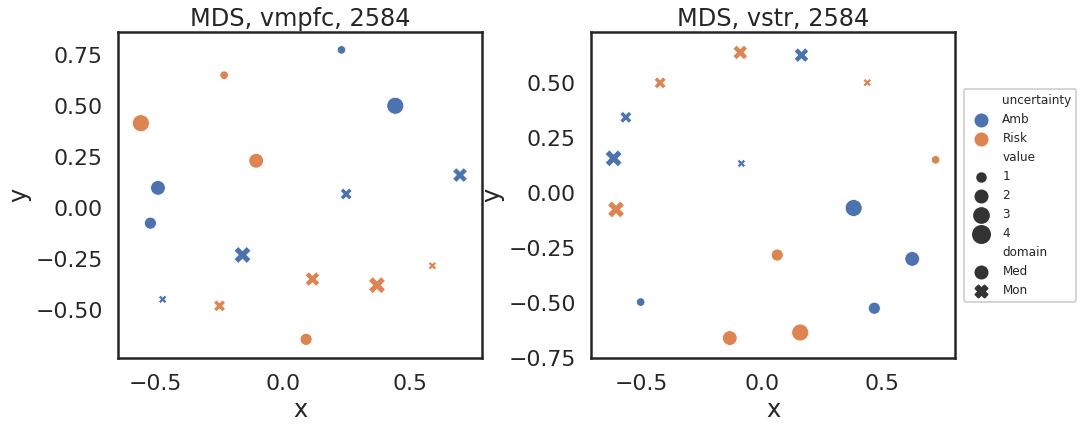

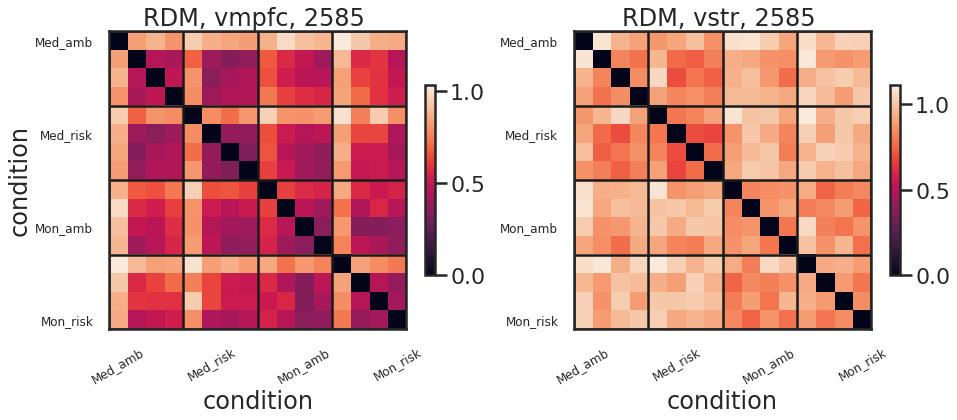

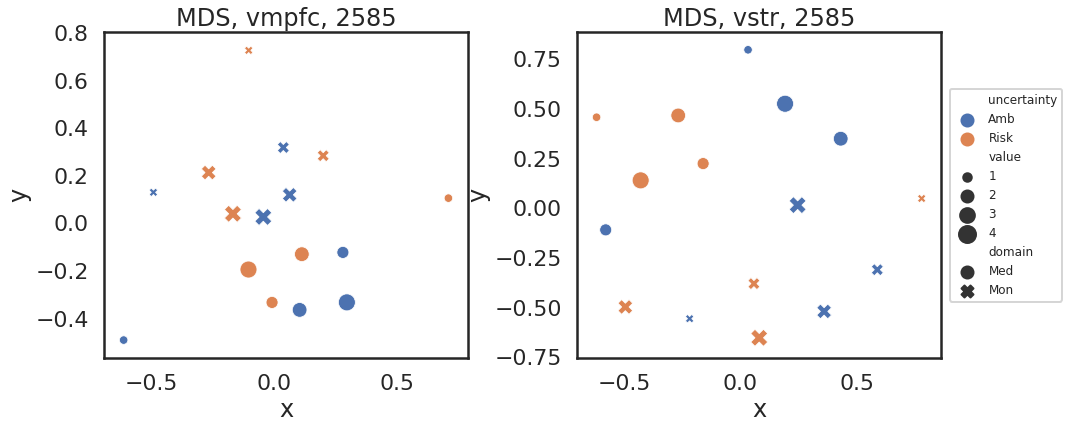

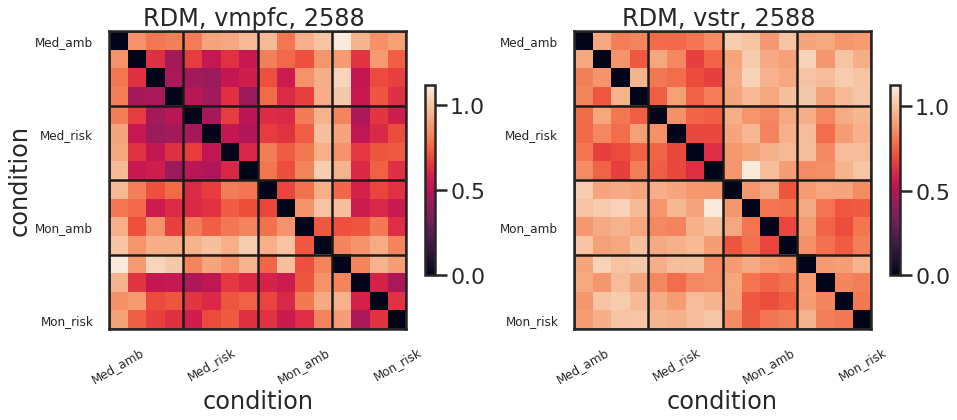

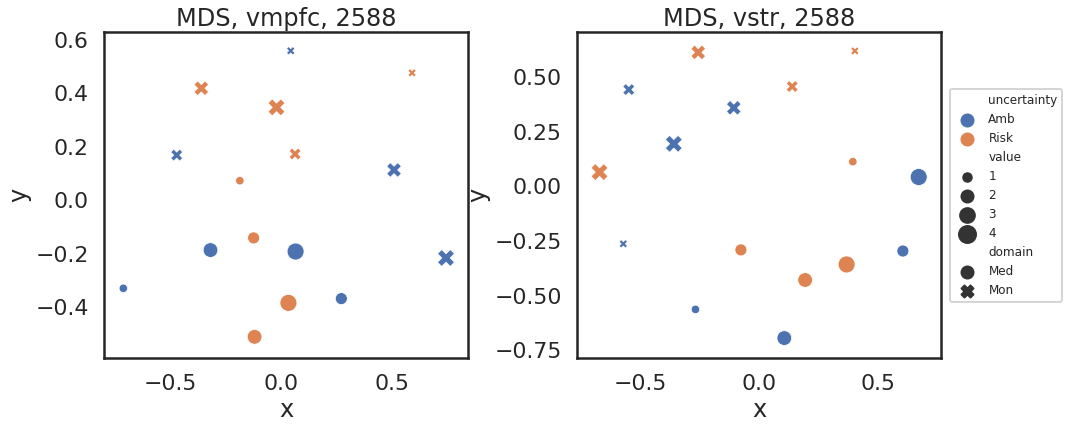

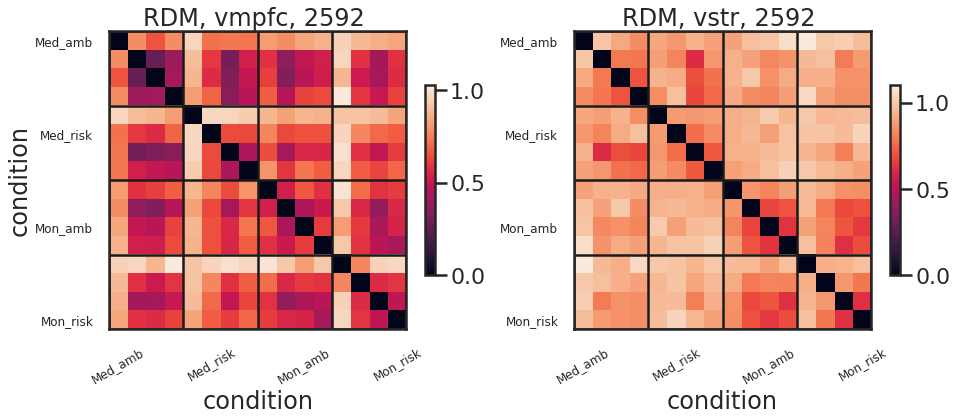

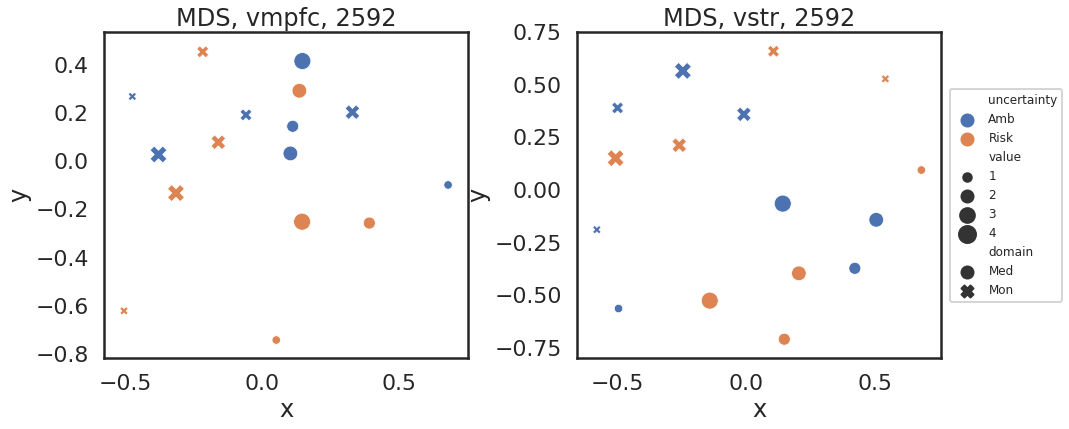

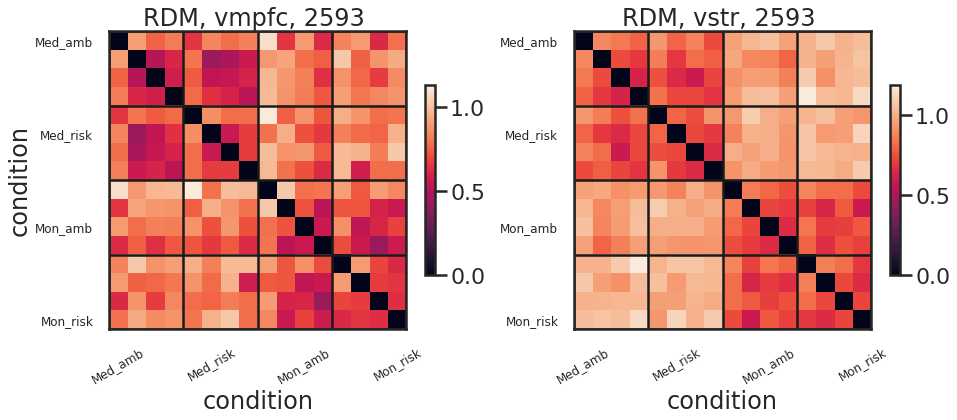

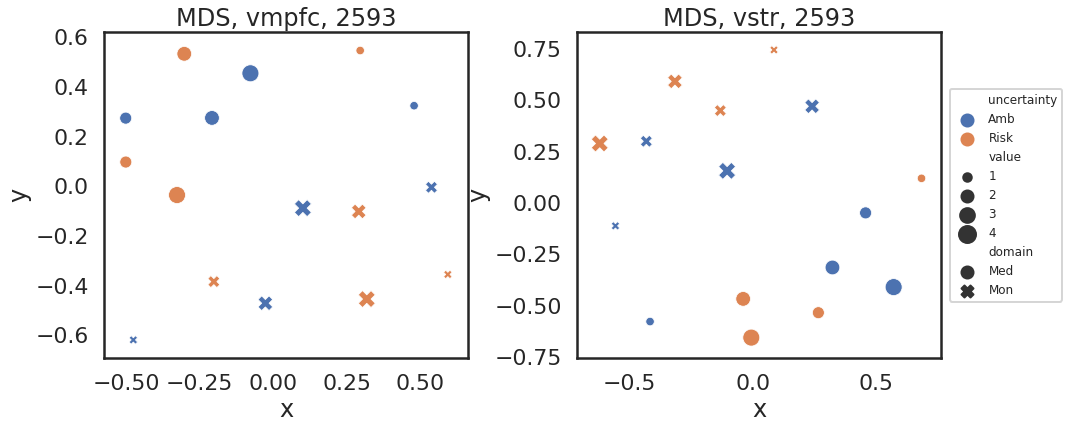

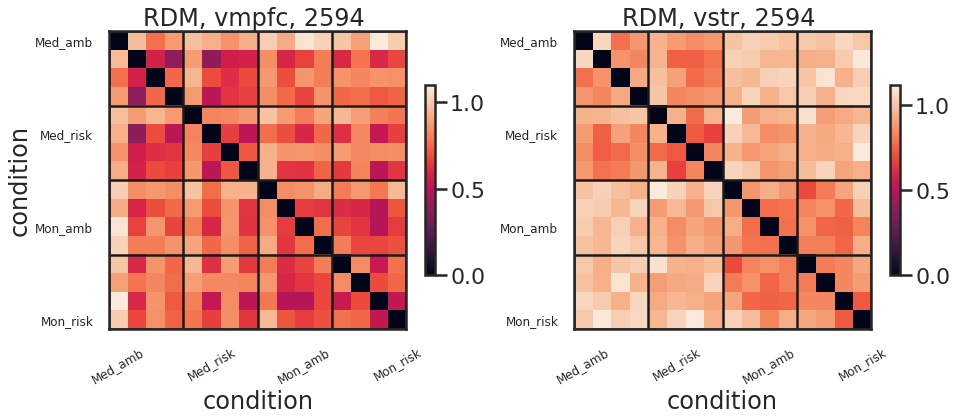

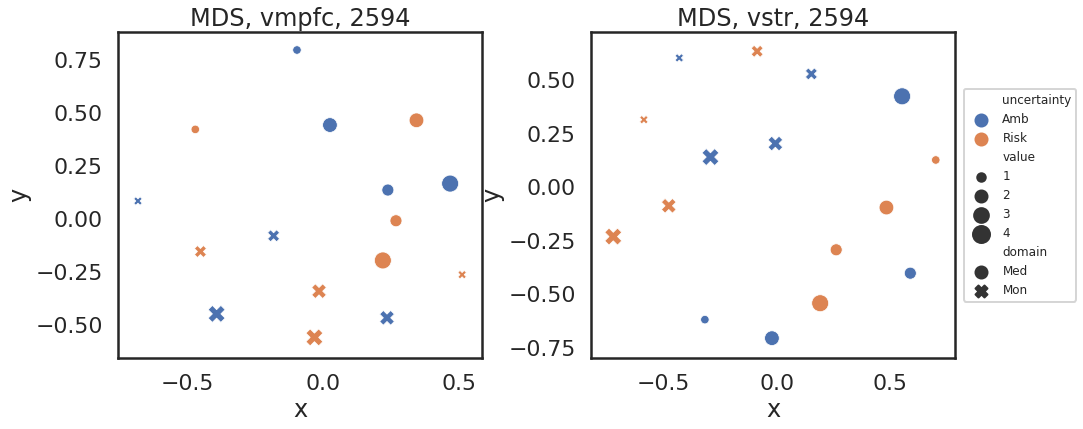

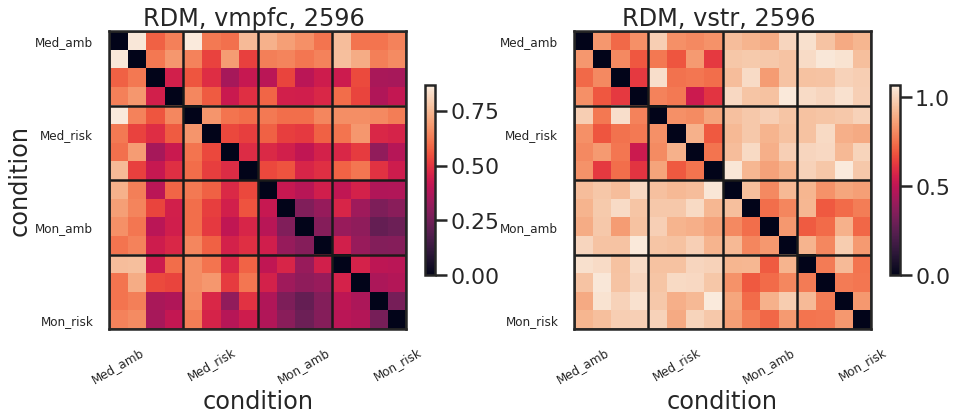

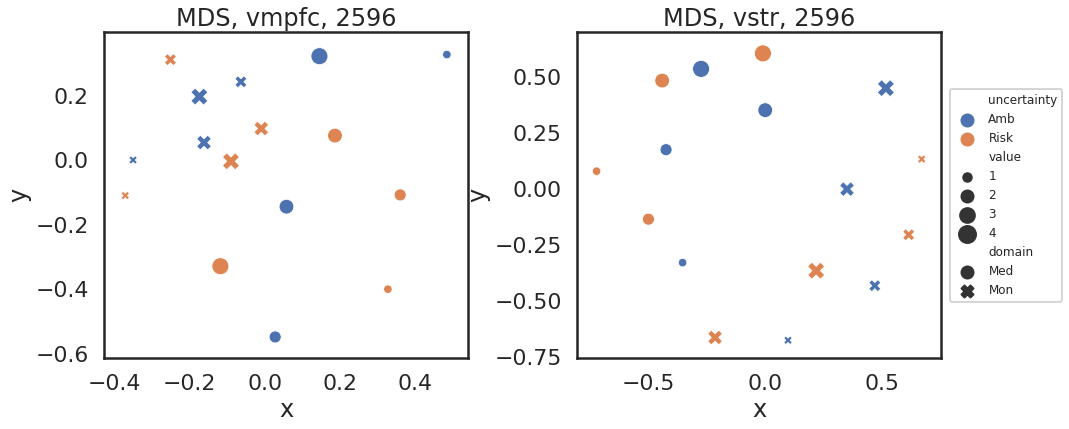

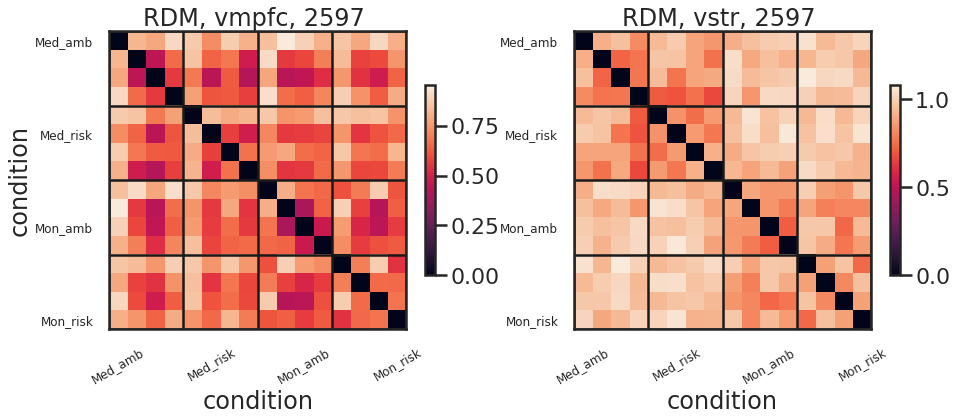

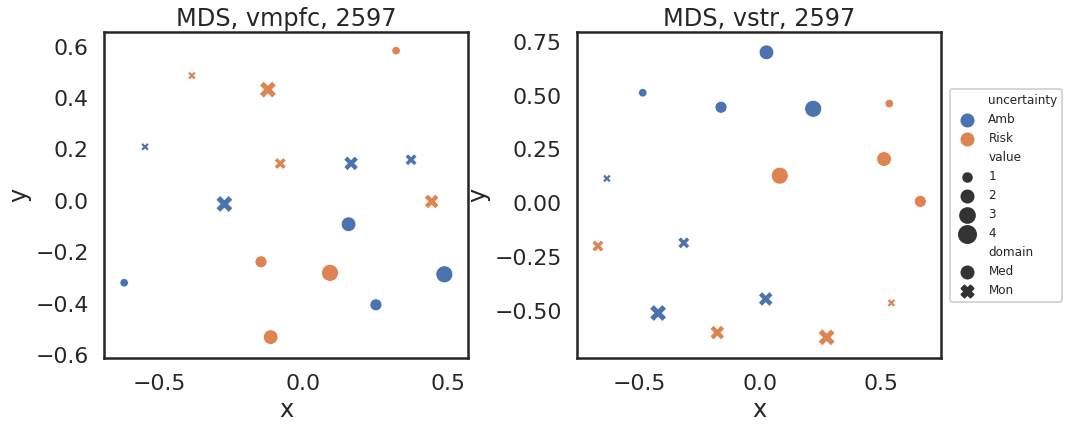

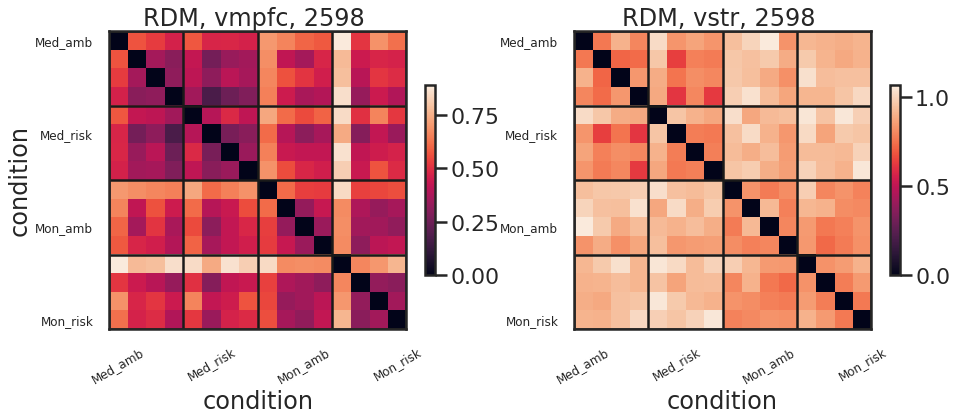

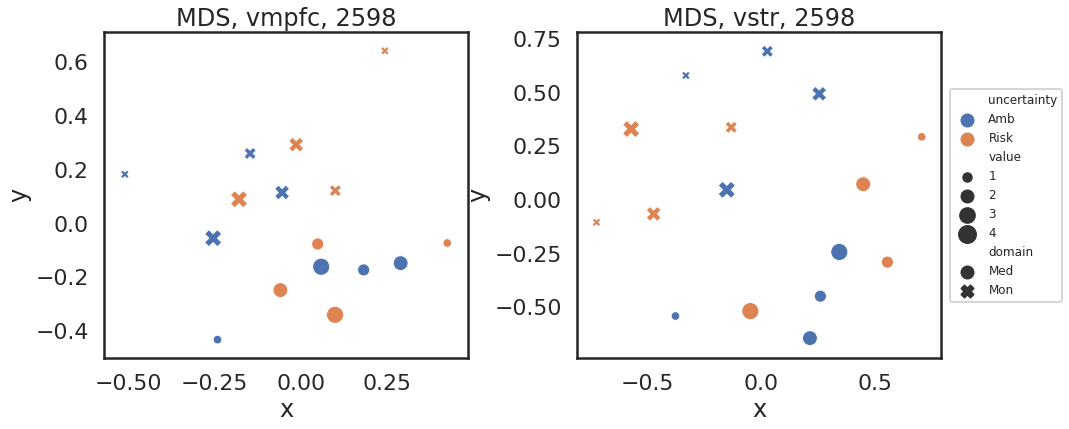

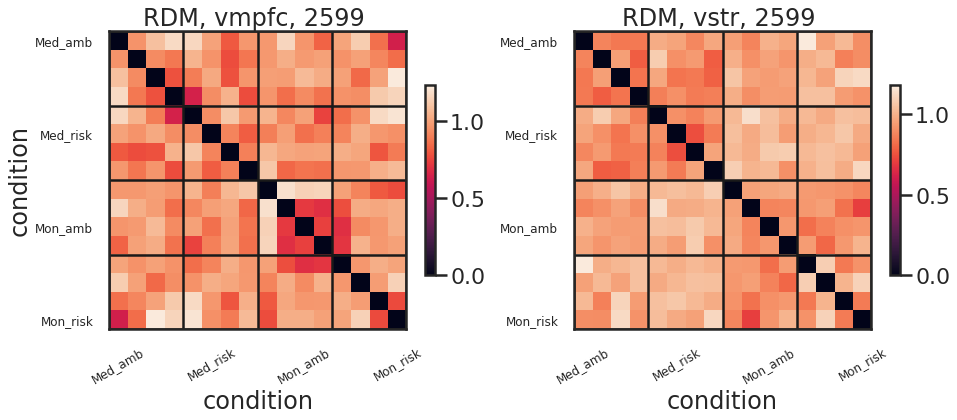

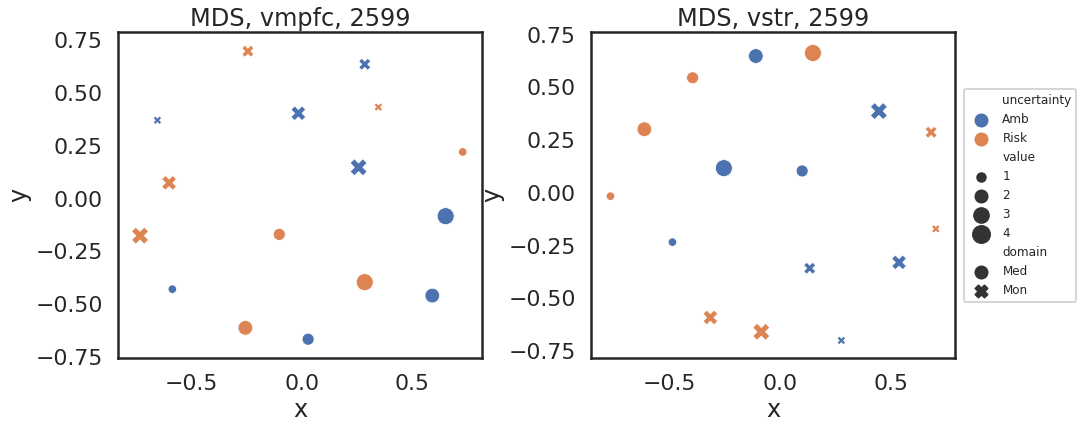

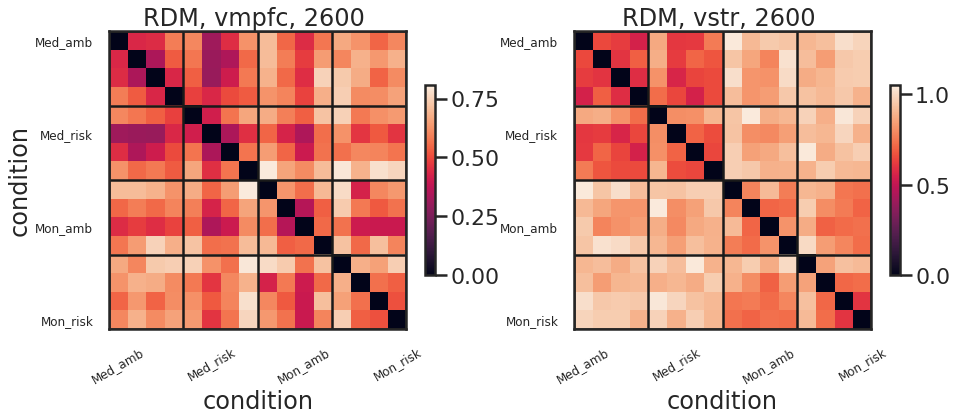

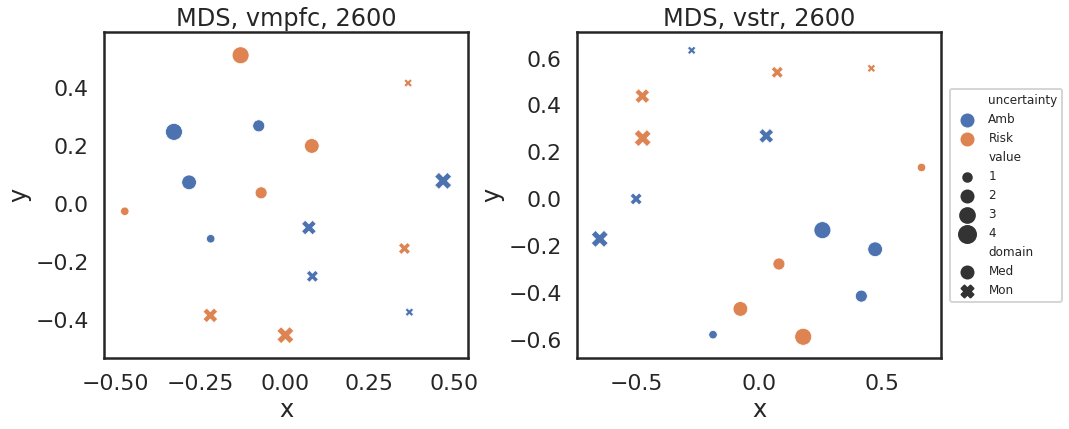

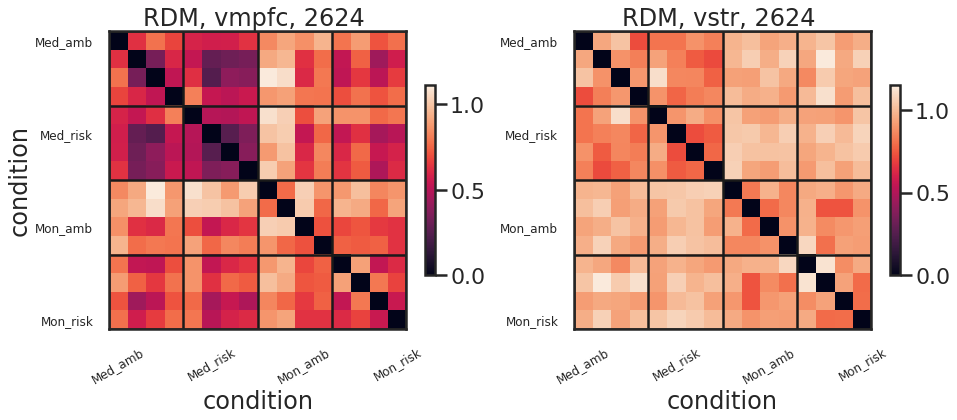

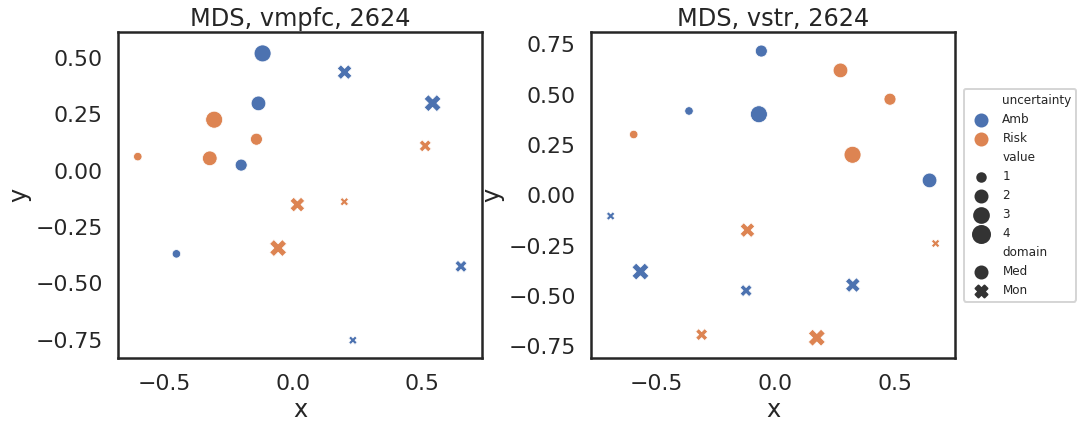

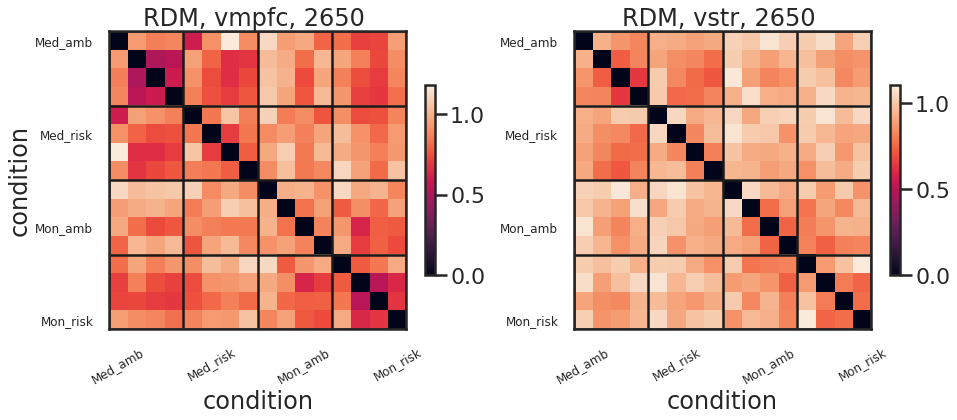

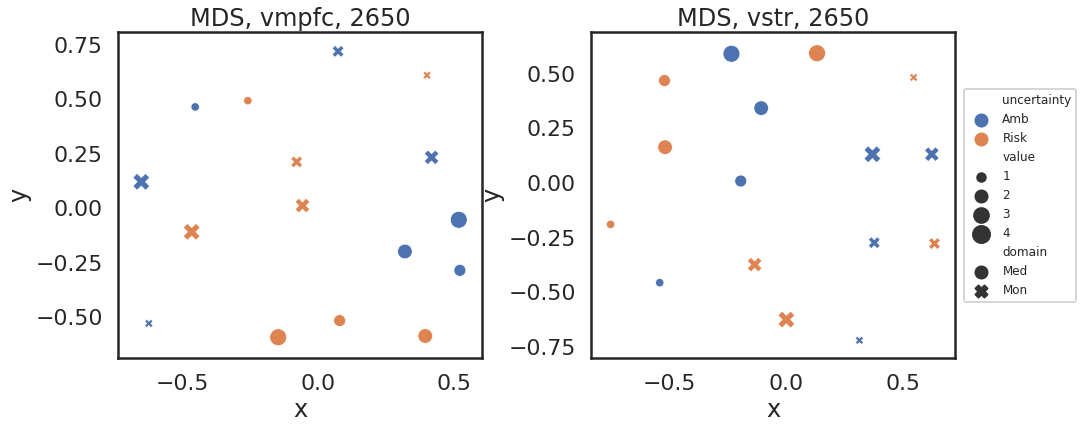

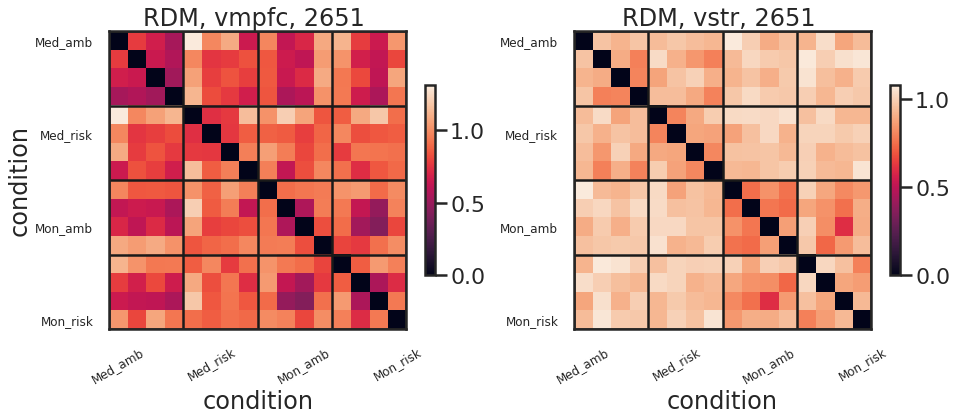

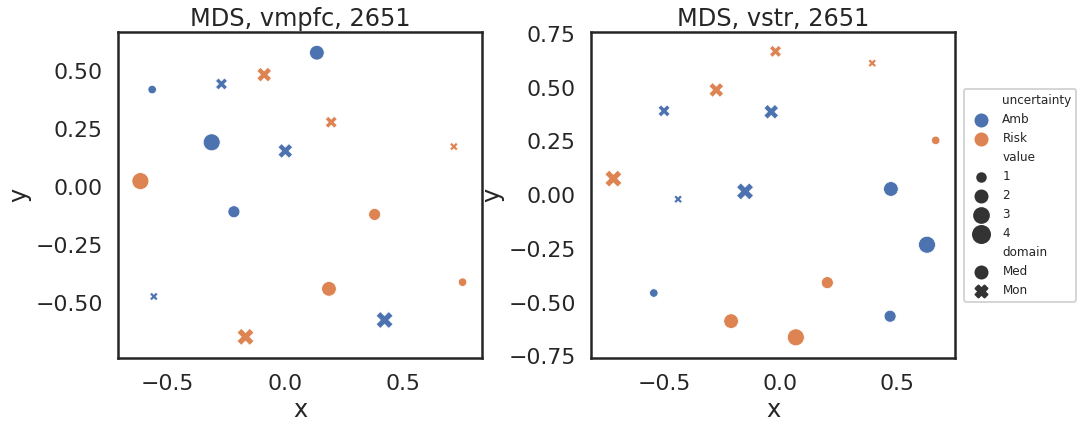

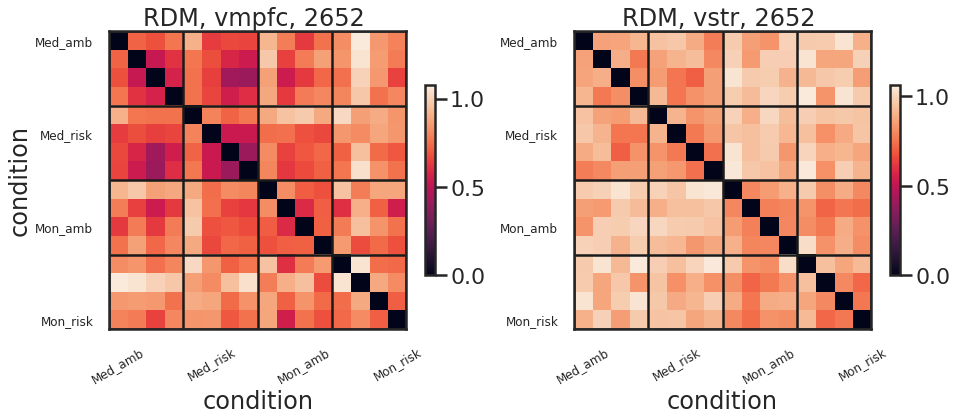

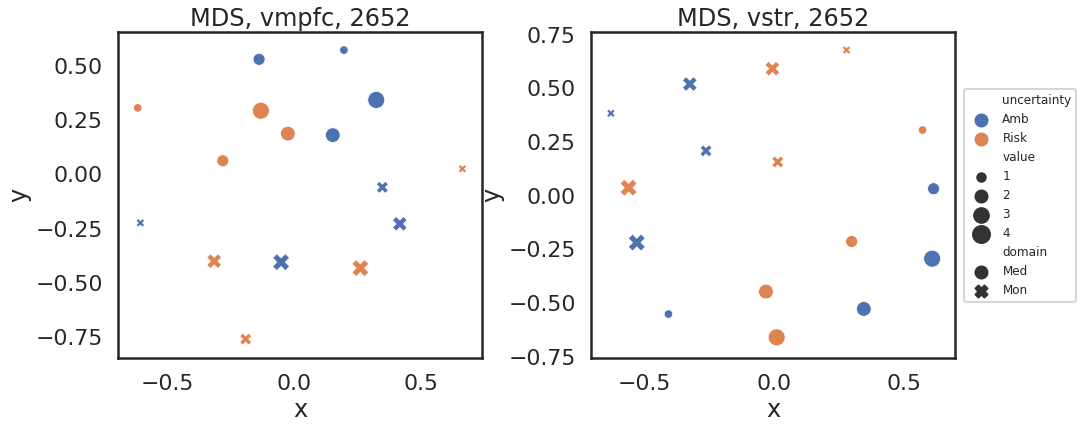

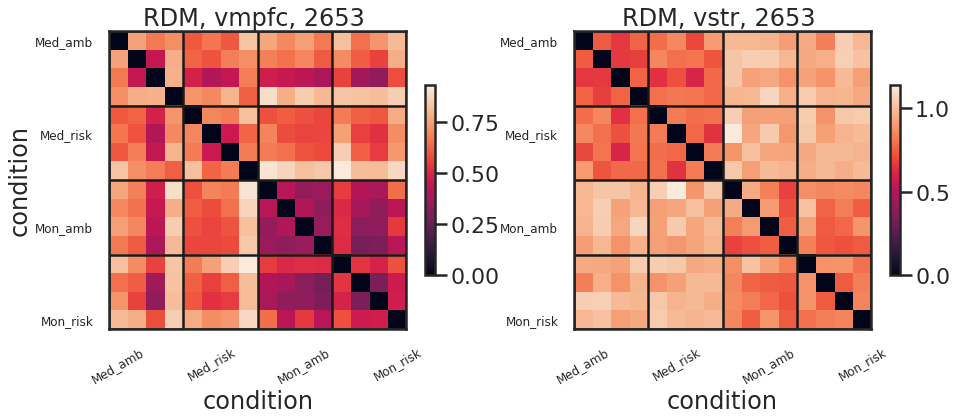

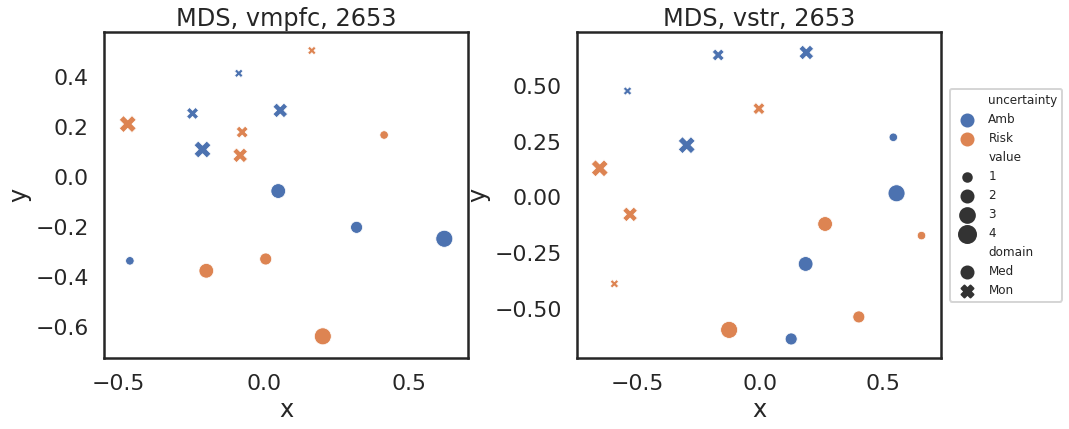

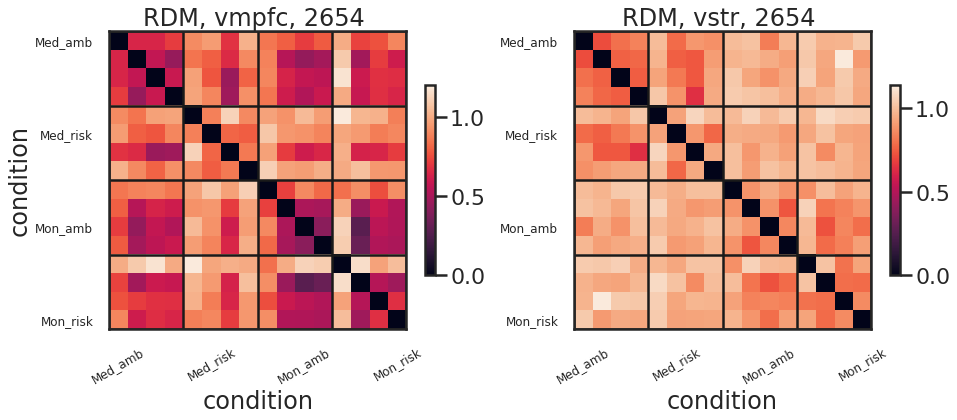

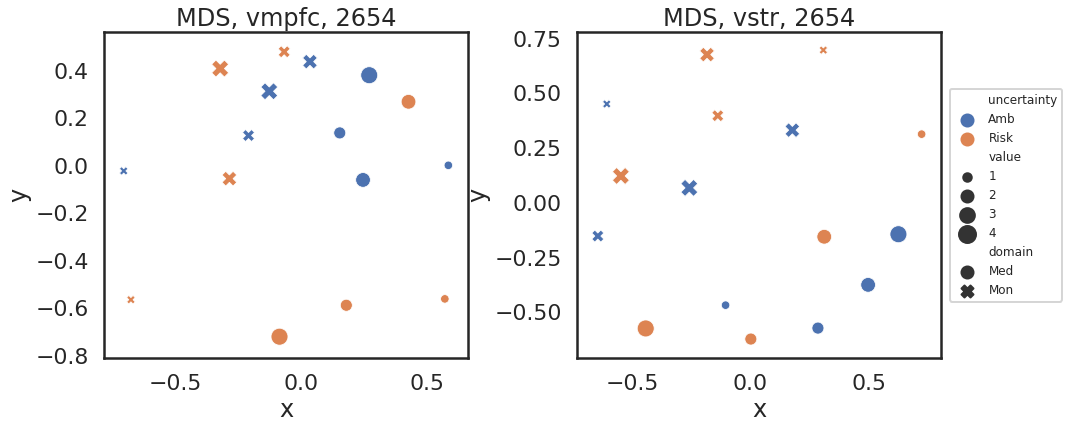

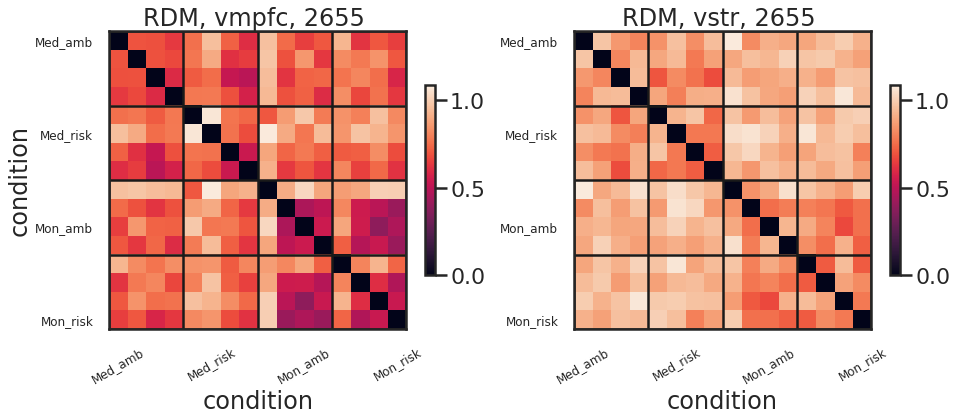

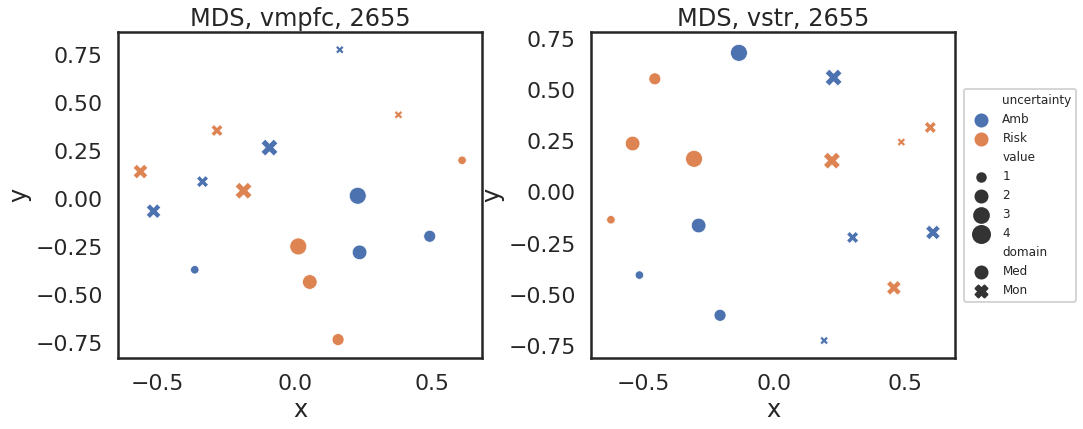

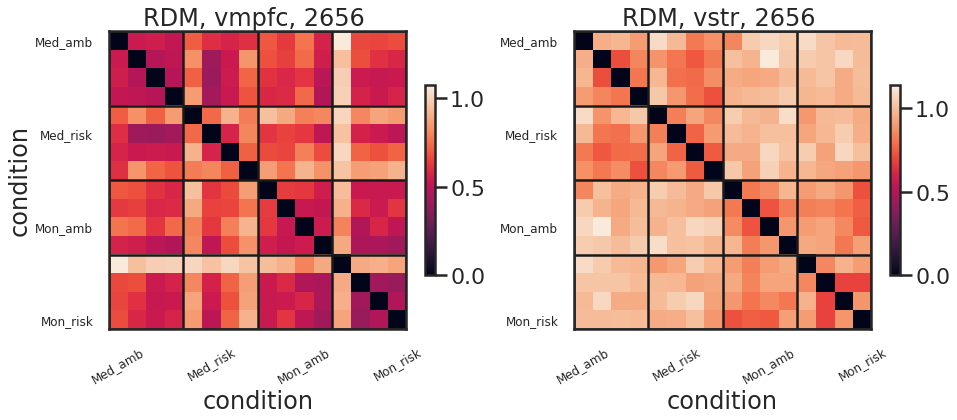

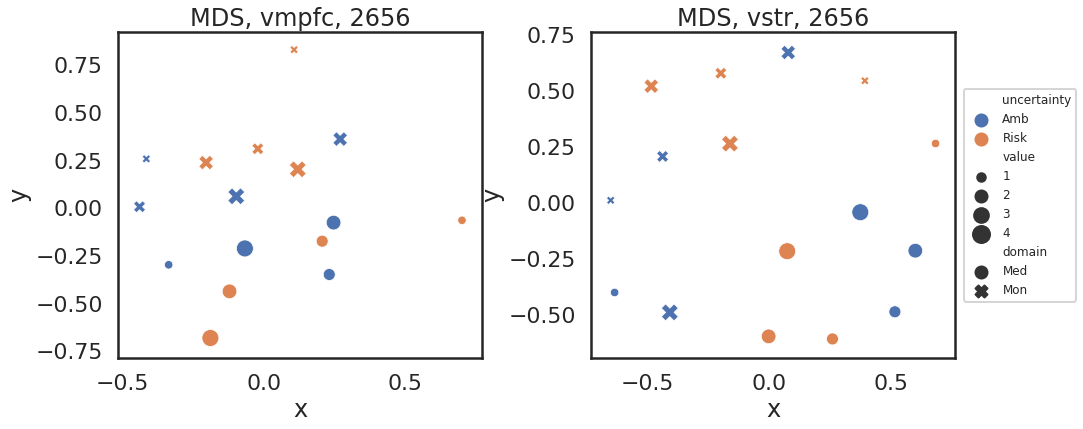

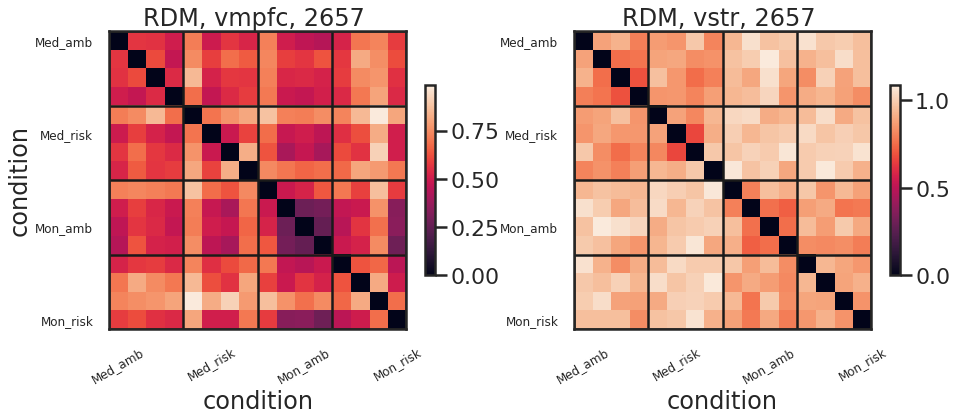

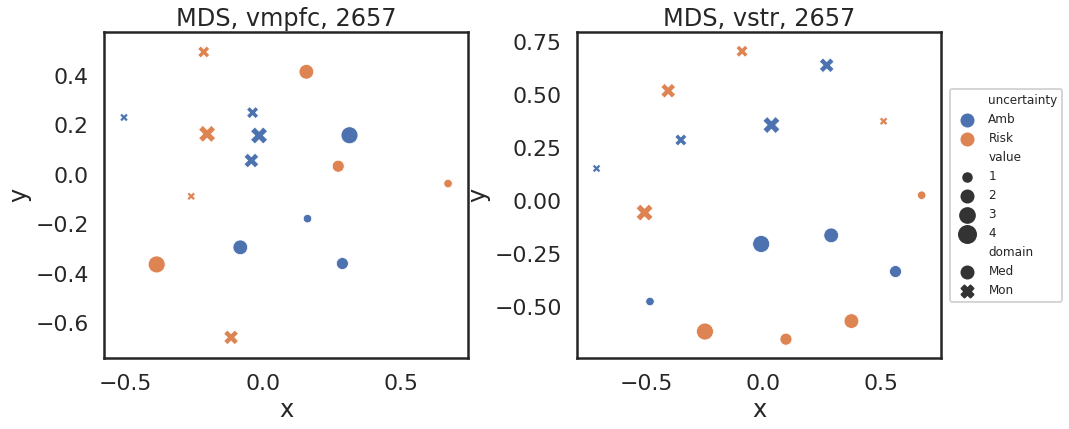

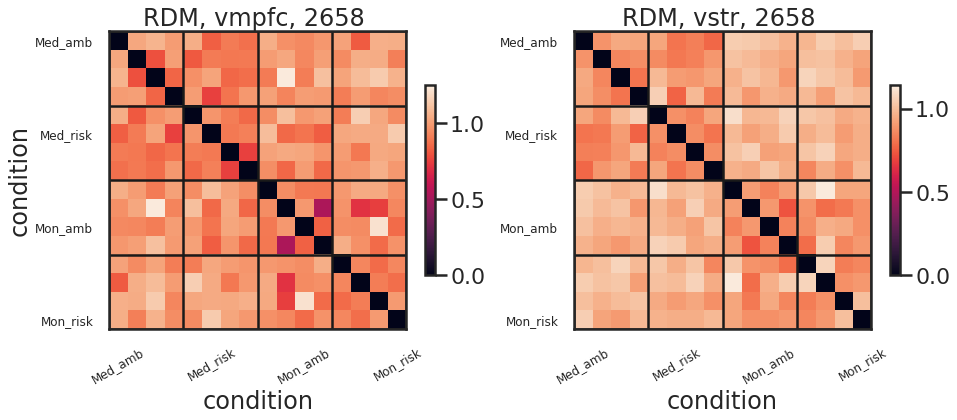

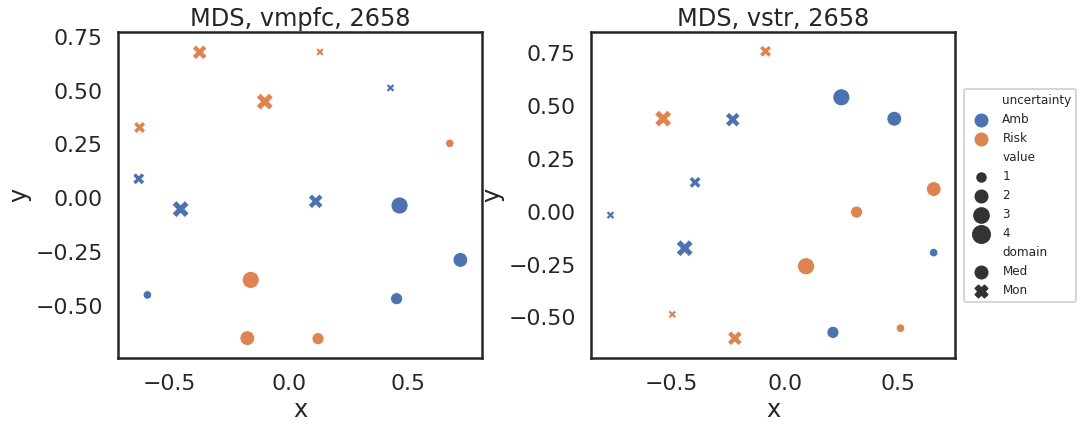

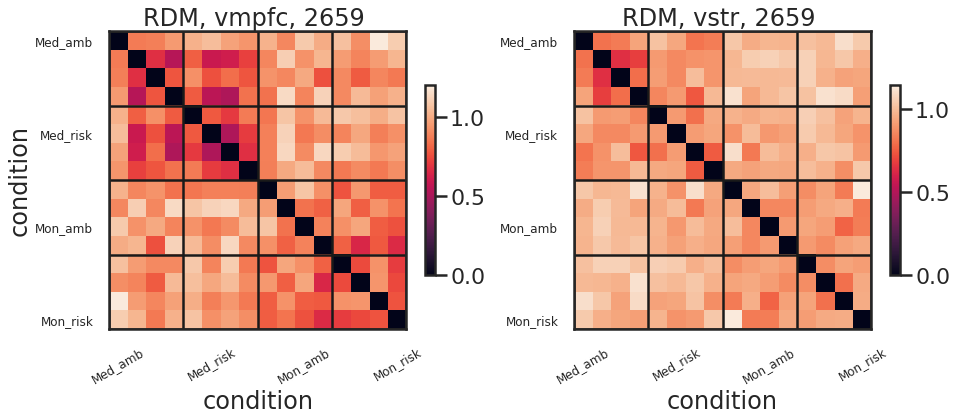

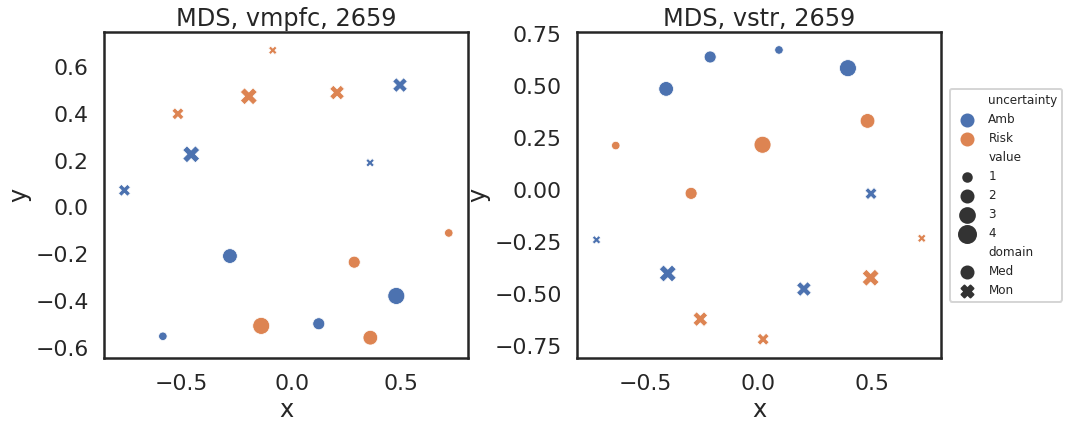

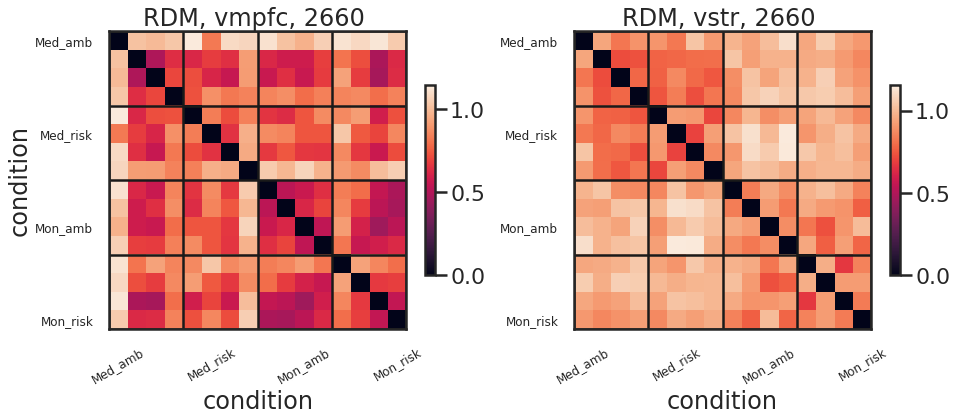

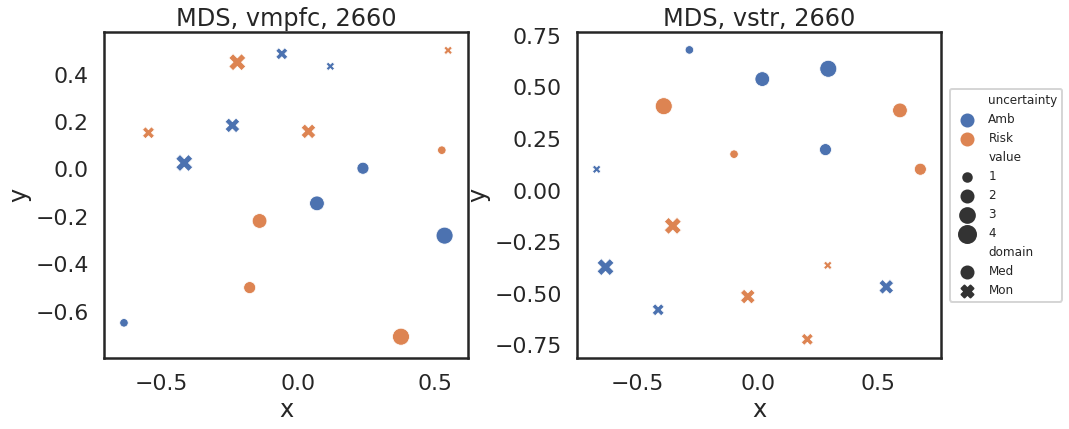

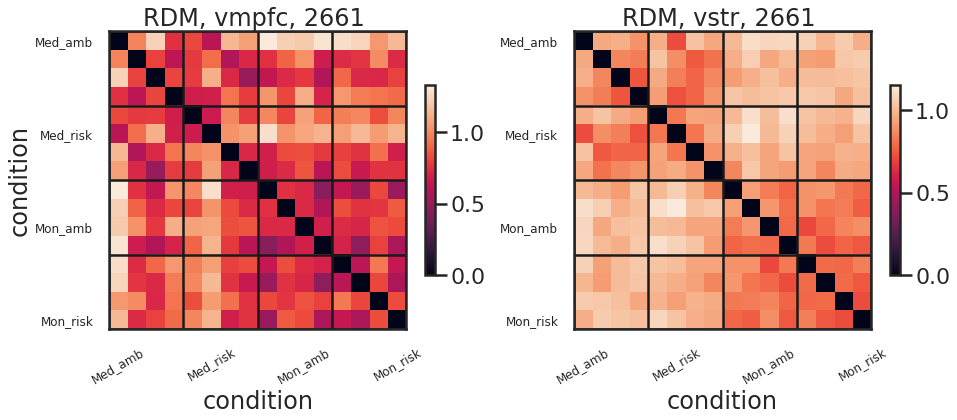

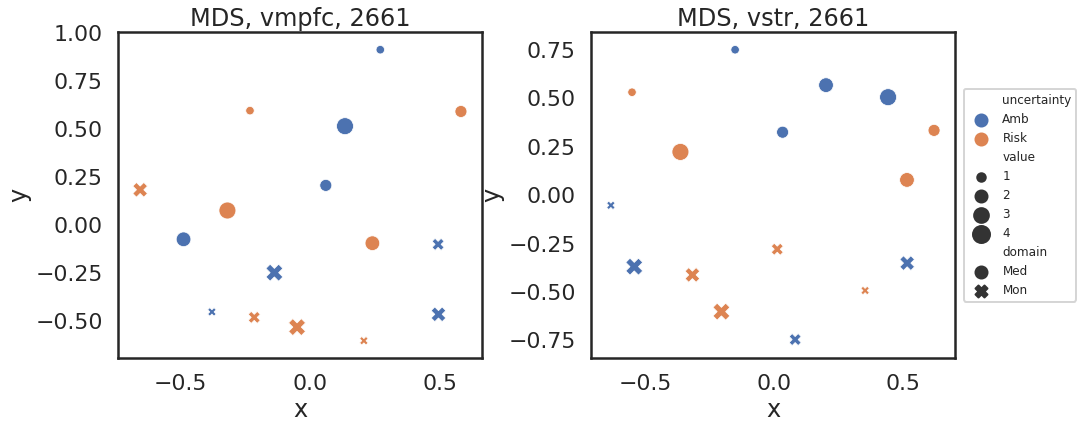

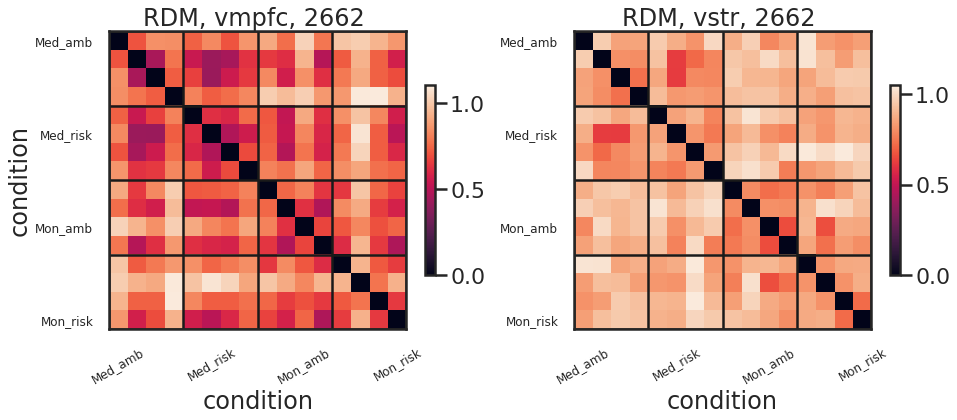

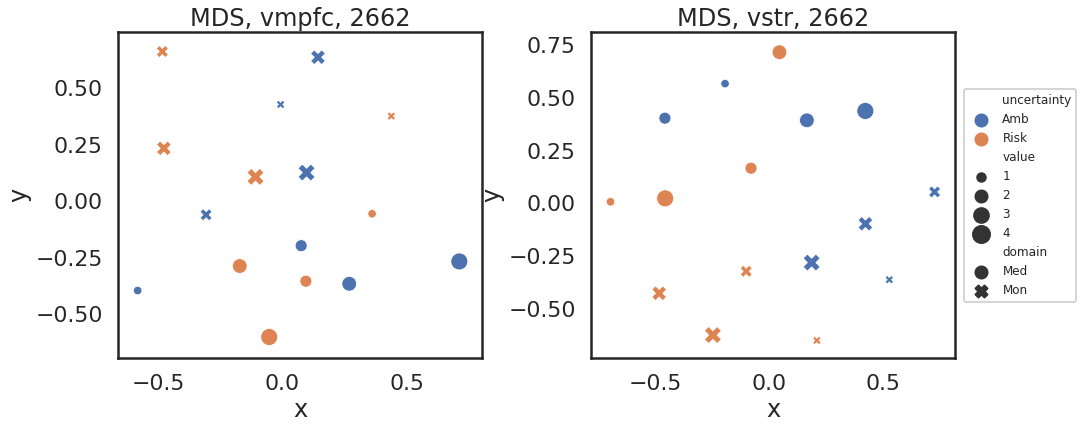

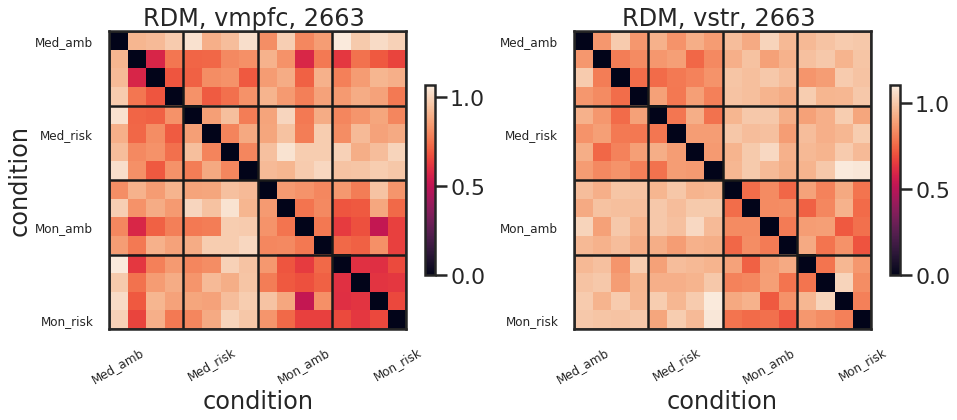

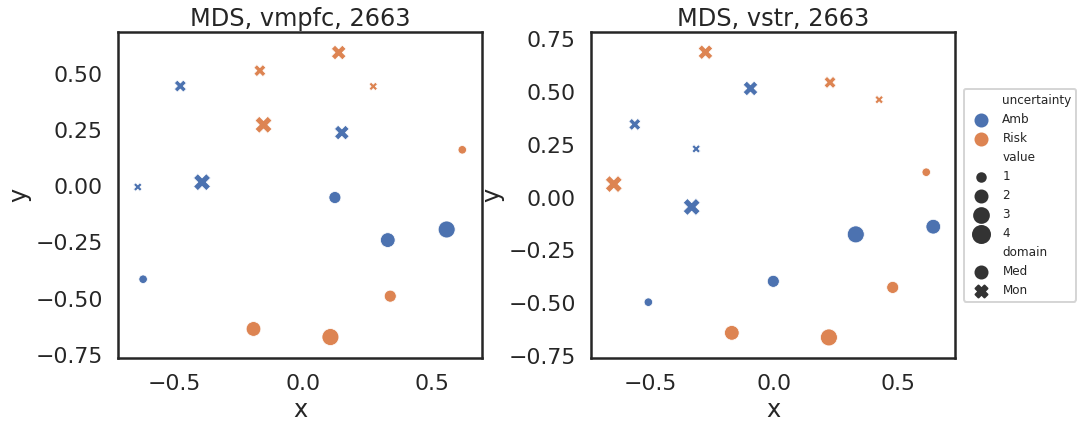

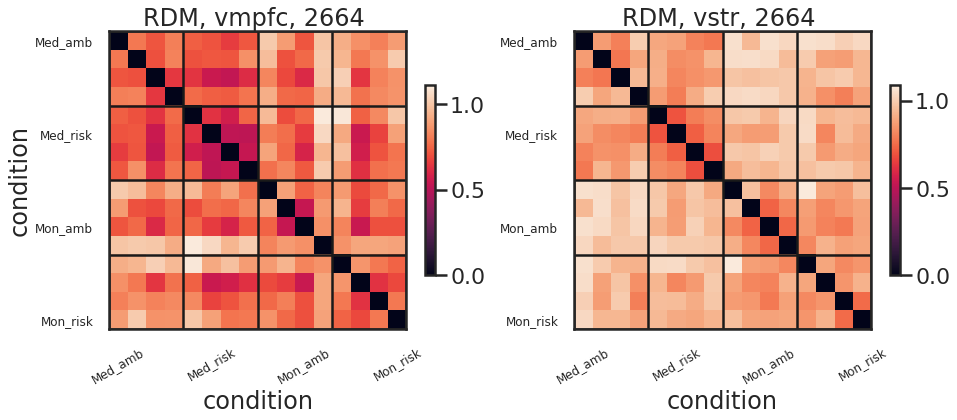

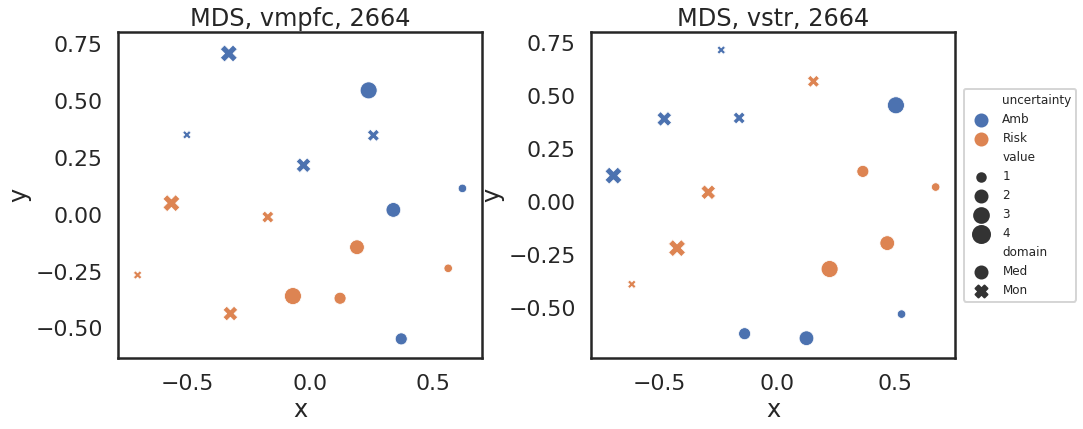

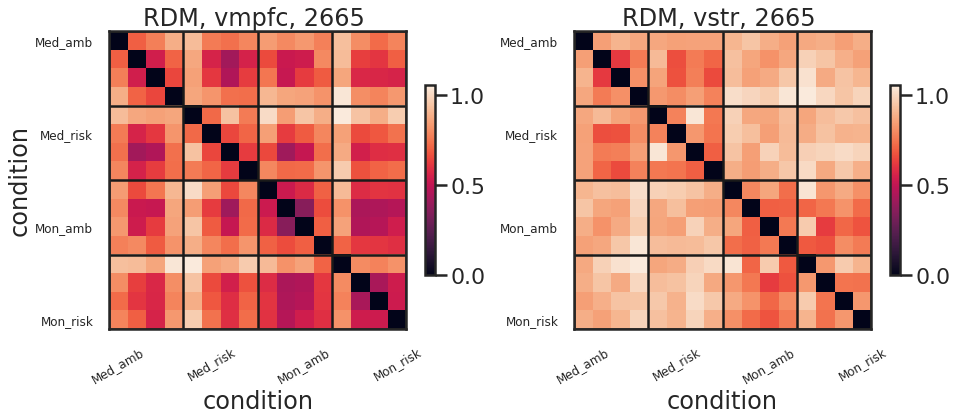

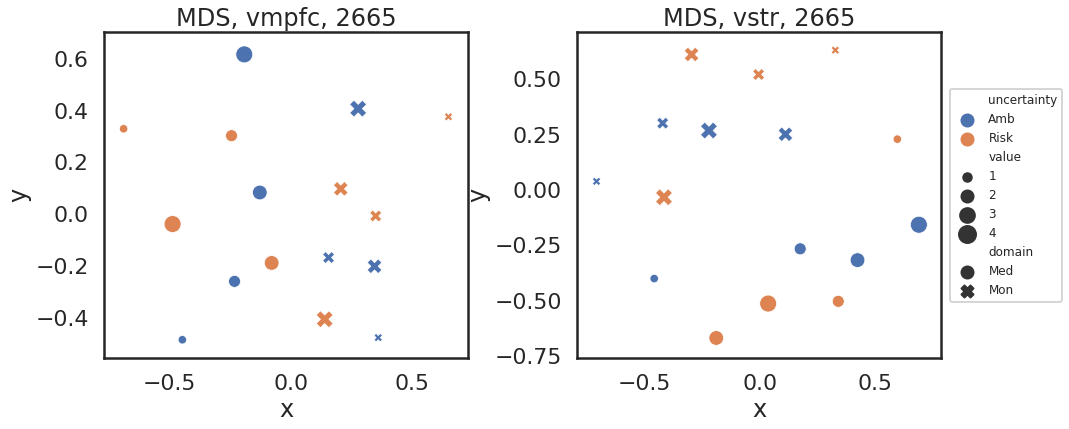

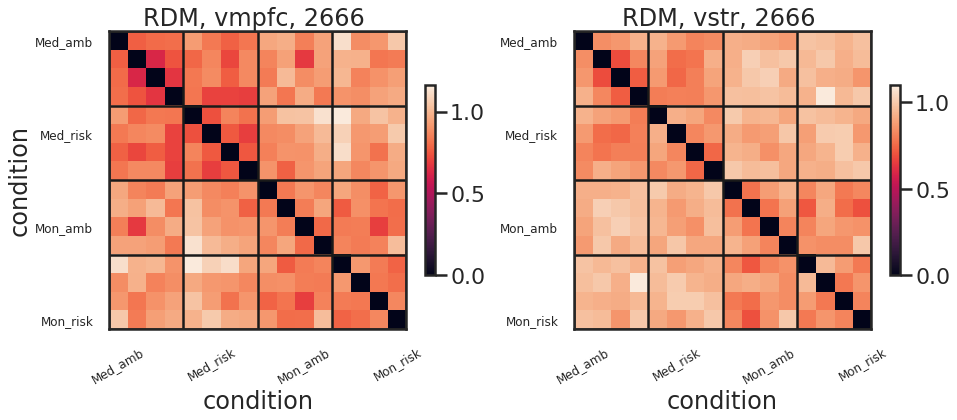

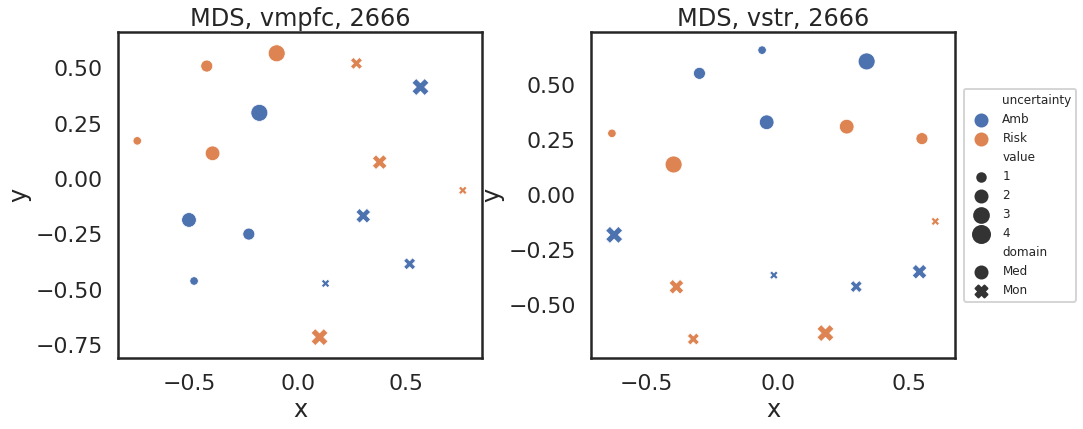

In [6]:
roi_names = ['vmpfc', 'vstr']
plot_roi_rdm(subjects, roi_names)

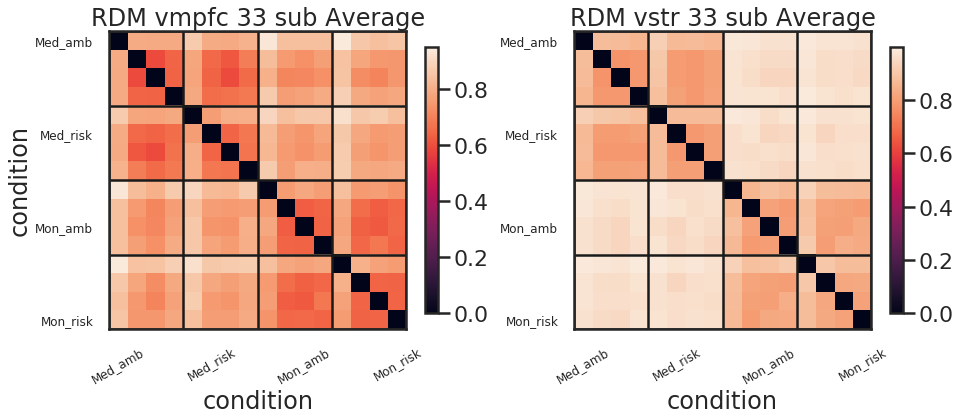

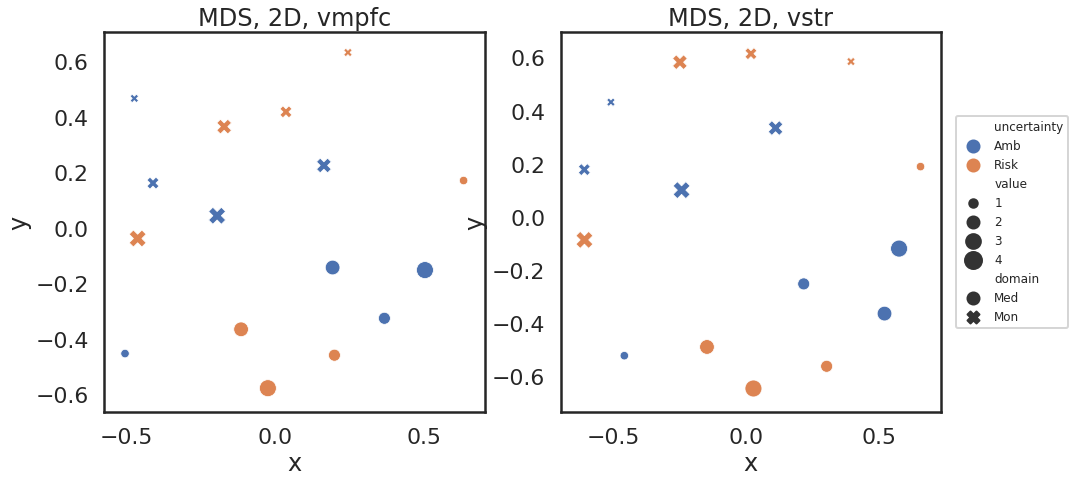

In [17]:
plot_roi_average_rdm(subjects, roi_names)

## PPC <a class = "anchor" id = "ppc-bullet"></a>

In [ ]:
roi_names = ['gilaie_rppc', 'zhang_val_lppc', 'levy_amb_ppc']

In [19]:
roi_names_all

['vmpfc',
 'vstr',
 'med_mon_1',
 'med_mon_2',
 'med_mon_3',
 'gilaie_rppc',
 'zhang_val_lppc',
 'zhang_val_lofc',
 'zhang_val_lingual',
 'zhang_sal_acc',
 'zhang_sal_lprecentral',
 'zhang_sal_lcaudate',
 'zhang_sal_rcaudate',
 'zhang_sal_linsula',
 'zhang_sal_rinsula',
 'zhang_sal_lingual',
 'levy_amb_striatum',
 'levy_amb_mpfc',
 'levy_amb_ppc',
 'levy_amb_lamyg',
 'levy_amb_sts',
 'levy_risk_striatum',
 'levy_risk_mpfc']